In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Datasets/Housing.csv'
dataset = pd.DataFrame(pd.read_csv(file_path))

In [ ]:
# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

In [ ]:
binary_vars =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

In [ ]:
dataset[binary_vars] = dataset[binary_vars].apply(binary_map)
# Preprocessing


components_to_use = ['area', 'bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning', 'parking', 'prefarea']
X = torch.tensor(dataset[components_to_use].values.copy(), dtype=torch.float32)

scaler = MinMaxScaler()
dataset[num_vars] = scaler.fit_transform(dataset[num_vars])
X_n = torch.tensor(dataset[components_to_use].values.copy(), dtype=torch.float32)

Y = torch.tensor(dataset.pop('price').values, dtype=torch.float32)

In [ ]:
n_samples = X.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

Xtrain = X[train_indices]
Ytrain = Y[train_indices]

Xtest = X[val_indices]
Ytest = Y[val_indices]

Xn_train = X_n[train_indices]
Xn_test = X_n[val_indices]

In [ ]:

def training_loop(nEpochs, optimizer, model, loss_fn, Xtrain, Xtest, Ytrain, Ytest):
  plotted_loss = np.zeros(nEpochs)
  for epoch in range(1, nEpochs + 1):
    Ypred_train = model(Xtrain)
    train_loss = loss_fn(Ypred_train, Ytrain)

    with torch.no_grad(): # <1>
      Ypred_test = model(Xtest)
      test_loss = loss_fn(Ypred_test, Ytest)
      plotted_loss[epoch - 1] = test_loss
      assert test_loss.requires_grad == False # <2>

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    if ((epoch == 1) or (epoch % 1000 == 0)):
      print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {test_loss.item():.4f}")

  return plotted_loss

In [ ]:

linear_model = nn.Linear(X.shape[1], 1)

seq_model_1 = nn.Sequential(
  nn.Linear(X.shape[1], 32),
  nn.Tanh(),
  nn.Linear(32, 1)
)

seq_model_2 = nn.Sequential(
  nn.Linear(X.shape[1], 32),
  nn.Tanh(),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 16),
  nn.Tanh(),
  nn.Linear(16, 1)
)

In [ ]:
linear_optimizer = optim.SGD(linear_model.parameters(), lr=1e-3)
seq_optimizer_1 = optim.SGD(seq_model_1.parameters(), lr=1e-3)
seq_optimizer_2 = optim.SGD(seq_model_2.parameters(), lr=1e-3)

epochs = 10000

In [ ]:
###Linear regression model
lin_reg = training_loop(
    nEpochs = epochs,
    optimizer = linear_optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    Xtrain = Xn_train, # <1>
    Xtest = Xn_test, # <1>
    Ytrain = Ytrain,
    Ytest = Ytest)

Epoch 1, Training loss 0.1328, Validation loss 0.1585
Epoch 1000, Training loss 0.0508, Validation loss 0.0551
Epoch 2000, Training loss 0.0409, Validation loss 0.0452
Epoch 3000, Training loss 0.0356, Validation loss 0.0398
Epoch 4000, Training loss 0.0326, Validation loss 0.0367
Epoch 5000, Training loss 0.0307, Validation loss 0.0348
Epoch 6000, Training loss 0.0295, Validation loss 0.0334
Epoch 7000, Training loss 0.0286, Validation loss 0.0325
Epoch 8000, Training loss 0.0280, Validation loss 0.0317
Epoch 9000, Training loss 0.0276, Validation loss 0.0312
Epoch 10000, Training loss 0.0273, Validation loss 0.0308


In [ ]:
##Single Sequence Model

single_seq = training_loop(
    nEpochs = epochs,
    optimizer = seq_optimizer_1,
    model = seq_model_1,
    loss_fn = nn.MSELoss(),
    Xtrain = Xn_train, # <1>
    Xtest = Xn_test, # <1>
    Ytrain = Ytrain,
    Ytest = Ytest)

Epoch 1, Training loss 0.0585, Validation loss 0.0637
Epoch 1000, Training loss 0.0326, Validation loss 0.0361
Epoch 2000, Training loss 0.0293, Validation loss 0.0324
Epoch 3000, Training loss 0.0277, Validation loss 0.0306
Epoch 4000, Training loss 0.0269, Validation loss 0.0297
Epoch 5000, Training loss 0.0264, Validation loss 0.0292
Epoch 6000, Training loss 0.0261, Validation loss 0.0290
Epoch 7000, Training loss 0.0260, Validation loss 0.0288
Epoch 8000, Training loss 0.0259, Validation loss 0.0287
Epoch 9000, Training loss 0.0258, Validation loss 0.0287
Epoch 10000, Training loss 0.0258, Validation loss 0.0286


In [ ]:
##Multiple seqence training loop
multi_seq = training_loop(
    nEpochs = epochs,
    optimizer = seq_optimizer_2,
    model = seq_model_2,
    loss_fn = nn.MSELoss(),
    Xtrain = Xn_train, # <1>
    Xtest = Xn_test, # <1>
    Ytrain = Ytrain,
    Ytest = Ytest)


Epoch 1, Training loss 0.0412, Validation loss 0.0486
Epoch 1000, Training loss 0.0259, Validation loss 0.0289
Epoch 2000, Training loss 0.0258, Validation loss 0.0288
Epoch 3000, Training loss 0.0258, Validation loss 0.0288
Epoch 4000, Training loss 0.0258, Validation loss 0.0288
Epoch 5000, Training loss 0.0258, Validation loss 0.0287
Epoch 6000, Training loss 0.0257, Validation loss 0.0287
Epoch 7000, Training loss 0.0257, Validation loss 0.0287
Epoch 8000, Training loss 0.0257, Validation loss 0.0287
Epoch 9000, Training loss 0.0257, Validation loss 0.0286
Epoch 10000, Training loss 0.0257, Validation loss 0.0286


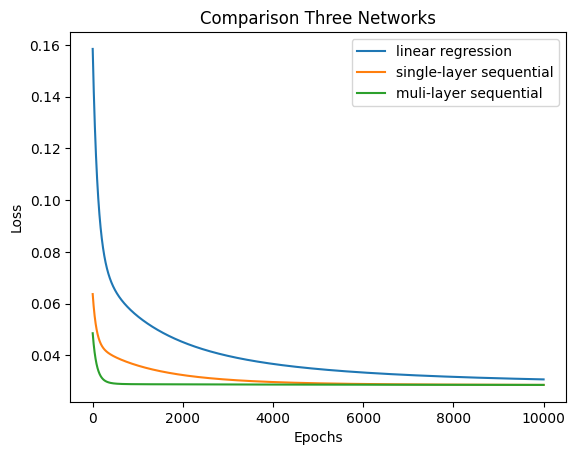

In [ ]:
##time to plot the losses of epochs
plt.plot(range(epochs), lin_reg, label='linear regression')
plt.plot(range(epochs), single_seq, label='single-layer sequential')
plt.plot(range(epochs), multi_seq, label='muli-layer sequential')

#Labeling graph
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison Three Networks')

# Adding legend
plt.legend()

# Show the plot
plt.show()

